In [427]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('cm1.arff')
df = pd.DataFrame(data[0])

df.defects = df.defects.astype('category')
df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,b'false'
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,b'true'
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1.0,0.0,6.0,0.0,15.0,15.0,44.0,19.0,9.0,b'false'
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0.0,0.0,3.0,0.0,16.0,8.0,31.0,16.0,7.0,b'false'
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0.0,0.0,3.0,0.0,16.0,12.0,46.0,26.0,11.0,b'false'


In [387]:
df.dtypes
# df.defects

loc                   float64
v(g)                  float64
ev(g)                 float64
iv(g)                 float64
n                     float64
v                     float64
l                     float64
d                     float64
i                     float64
e                     float64
b                     float64
t                     float64
lOCode                float64
lOComment             float64
lOBlank               float64
locCodeAndComment     float64
uniq_Op               float64
uniq_Opnd             float64
total_Op              float64
total_Opnd            float64
branchCount           float64
defects              category
dtype: object

In [407]:
from sklearn.model_selection import KFold
import time

def crossValidation(df, alg, *args):    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(df)
    
    kValues = [1,2,3,5,7,9,11,13,15]
    results = []
    for k in kValues:
        print('K = %d' % k)
        fold = 1
        execTime = []
        accuracy = []
        for train_index, test_index in kf.split(df):
            start = time.time()
            correct = 0
            if (args):
                radious = args[0](df)
            for i in test_index:
                if args:
                    response = alg(df.iloc[train_index], df.iloc[i], k, radious)
                else:
                    response = alg(df.iloc[train_index], df.iloc[i], k)
                if (response == True and df.iloc[i].defects == bytes('true', 'utf-8') or (response == False and df.iloc[i].defects == bytes('false', 'utf-8'))):
                    correct += 1
            end = time.time()
            execTime.append(end - start)
            accuracy.append(correct/len(test_index))
            print(' - Fold %d: %f - %d/%d - time: %fs' % (fold, correct/len(test_index), correct, len(test_index), (end - start)))
            fold += 1
        a = sum(accuracy)/len(accuracy)
        t = sum(execTime)/len(execTime)
        results.append([k, a, t])
        print(' - Mean accuracy: %f' % a)
    return results

In [388]:
import math
def euclideanDistance(i1, i2):
    sum = 0
    for i in range(len(i1) - 1):
        sum += math.pow((i1[i] - i2[i]), 2)
    return math.sqrt(sum)

euclideanDistance(df.iloc[0].values[:len(df.iloc[0].values)-1], df.iloc[1].values[:len(df.iloc[1].values)-1])
type(df.iloc[0].values[-1])
# bytes('false', 'utf-8')

bytes

In [282]:
def knn(train_df, instance, k):
    distances = []
    numCols = len(train_df.iloc[1])
    for index, row in train_df.iterrows():
        i = row.values
        distances.append([euclideanDistance(instance[:numCols-1], i[:numCols-1]), index, row.defects])
        
    distances.sort(key=lambda x: x[0])
    distances = distances[:k]
    t = 0
    f = 0
    for i in distances:
        if i[2] == bytes('true', 'utf-8'):
            t += 1
        else:
            f += 1
    return t > f

In [406]:
crossValidation(df, knn)

K = 1
 - Fold 1: 0.850000 - 85/100 - time: 15.406982s
 - Fold 2: 0.840000 - 84/100 - time: 15.349388s
 - Fold 3: 0.850000 - 85/100 - time: 14.878690s
 - Fold 4: 0.868687 - 86/99 - time: 14.777837s
 - Fold 5: 0.909091 - 90/99 - time: 15.536740s
 - Mean accuracy: 0.863556


[[1, 0.8635555555555555, 15.189927434921264]]

In [277]:
def wknn(train_df, instance, k):
    distances = []
    numCols = len(train_df.iloc[1])
    for index, row in train_df.iterrows():
        i = row.values
        distances.append([euclideanDistance(instance[:numCols-1], i[:numCols-1]), index, row.defects])
    
    distances.sort(key=lambda x: x[0])
    distances = distances[:k]
    t = 0
    f = 0
    for i in distances:
        d = 0
        if i[0] > 0: d = 1/(i[0]**2)
        else: d = 0
        if i[2] == bytes('true', 'utf-8'):
            t += d
        else:
            f += d
    return t > f

In [332]:
crossValidation(df, wknn)

Fold 1: 0.880000 - 88/100
Fold 2: 0.820000 - 82/100
Fold 3: 0.820000 - 82/100
Fold 4: 0.888889 - 88/99
Fold 5: 0.919192 - 91/99


In [343]:
def getRadious(train_df):
    radious = []
    for i, rowI in train_df.iterrows():        
        r = 999999999999999999999999
        ri = 0
        for j, rowJ in train_df.iterrows():
            if rowI.defects != rowJ.defects:
                ri = euclideanDistance(rowI, rowJ) - 1
                if ri < r:
                    r = ri
        radious.append([i, r])
        radiousDf = pd.DataFrame(radious)
        radiousDf = radiousDf.set_index(0)
        radiousDf.columns = ['radious']
    return radiousDf

getRadious(df).head()

,radious
0,
0,1.351595
1,1.351595
2,126.821926
3,122.819903
4,478.375336


In [369]:
def aknn(train_df, instance, k, radious):
    distances = []
    numCols = len(train_df.iloc[1])
    for index, row in train_df.iterrows():
        i = row.values
        r = radious.iloc[index].radious
        distances.append([euclideanDistance(instance[:numCols-1], i[:numCols-1])/r, index, row.defects])
    
    distances.sort(key=lambda x: x[0])
    distances = distances[:k]
    t = 0
    f = 0
    for i in distances:
        d = 0
        if i[0] > 0: d = 1/(i[0]**2)
        else: d = 0
        if i[2] == bytes('true', 'utf-8'):
            t += d
        else:
            f += d
    return t > f

In [370]:
crossValidation(df, aknn, getRadious)

Fold 1: 0.910000 - 91/100
Fold 2: 0.940000 - 94/100
Fold 3: 0.910000 - 91/100
Fold 4: 0.909091 - 90/99
Fold 5: 0.888889 - 88/99


In [408]:
knnTest = crossValidation(df, knn)
wknnTest = crossValidation(df, wknn)
aknnTest = crossValidation(df, aknn, getRadious)

K = 1
 - Fold 1: 0.870000 - 87/100 - time: 15.375468s
 - Fold 2: 0.870000 - 87/100 - time: 15.353556s
 - Fold 3: 0.850000 - 85/100 - time: 15.086280s
 - Fold 4: 0.818182 - 81/99 - time: 14.993831s
 - Fold 5: 0.848485 - 84/99 - time: 14.973046s
 - Mean accuracy: 0.851333
K = 2
 - Fold 1: 0.870000 - 87/100 - time: 14.903145s
 - Fold 2: 0.940000 - 94/100 - time: 17.485059s
 - Fold 3: 0.830000 - 83/100 - time: 15.139883s
 - Fold 4: 0.878788 - 87/99 - time: 14.812679s
 - Fold 5: 0.909091 - 90/99 - time: 14.728564s
 - Mean accuracy: 0.885576
K = 3
 - Fold 1: 0.870000 - 87/100 - time: 14.780336s
 - Fold 2: 0.870000 - 87/100 - time: 14.552756s
 - Fold 3: 0.890000 - 89/100 - time: 14.516851s
 - Fold 4: 0.878788 - 87/99 - time: 14.526153s
 - Fold 5: 0.878788 - 87/99 - time: 14.729952s
 - Mean accuracy: 0.877515
K = 5
 - Fold 1: 0.880000 - 88/100 - time: 15.253087s
 - Fold 2: 0.860000 - 86/100 - time: 14.609989s
 - Fold 3: 0.860000 - 86/100 - time: 14.597859s
 - Fold 4: 0.878788 - 87/99 - time: 1

In [416]:
def testResultToDf(testResult):
    testResultDf = pd.DataFrame(testResult)
    testResultDf.columns = ['k', 'accuracy', 'execTime']
    testResultDf = testResultDf.set_index('k')
    return testResultDf

In [419]:
knnTestDf = testResultToDf(knnTest)
wknnTestDf = testResultToDf(wknnTest)
aknnTestDf = testResultToDf(aknnTest)

In [421]:
def saveDfIntoCsv(df, fileName):
    csvDf = df.to_csv()
    f = open('./%s.csv' % fileName, 'w')
    f.write(csvDf)
    f.close()

In [424]:
saveDfIntoCsv(knnTestDf, 'knnTest')
saveDfIntoCsv(wknnTestDf, 'wKnnTest')
saveDfIntoCsv(aknnTestDf, 'aKnnTest')

In [429]:
knnTestDf

,accuracy,execTime
k,,
1,0.851333,15.156436
2,0.885576,15.413866
3,0.877515,14.621210
5,0.879596,14.671406
7,0.901576,14.512965
9,0.897636,14.784790
11,0.901636,14.498668
13,0.901657,14.529374
15,0.901576,14.547930


In [446]:
accuracyDf = pd.DataFrame(knnTestDf['accuracy'])
accuracyDf.columns = ['KNN']
accuracyDf['W KNN'] = wknnTestDf['accuracy']
accuracyDf['A KNN'] = aknnTestDf['accuracy']
accuracyDf

,KNN,W KNN,A KNN
k,,,
1,0.851333,0.831394,0.901616
2,0.885576,0.833414,0.905657
3,0.877515,0.855455,0.893495
5,0.879596,0.869576,0.915596
7,0.901576,0.877475,0.919596
9,0.897636,0.875556,0.911636
11,0.901636,0.887495,0.915576
13,0.901657,0.881556,0.907535
15,0.901576,0.869475,0.905596


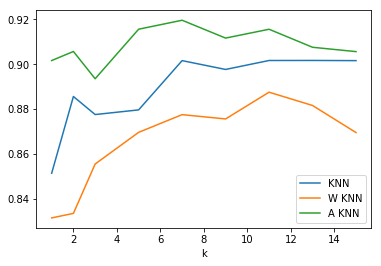

In [447]:
accuracyDf.plot.line()

In [453]:
execTimeDf = pd.DataFrame(knnTestDf['execTime'])
execTimeDf.columns = ['KNN']
execTimeDf['W KNN'] = wknnTestDf['execTime']
execTimeDf['A KNN'] = aknnTestDf['execTime']
execTimeDf

,KNN,W KNN,A KNN
k,,,
1,15.156436,14.620053,1749.898899
2,15.413866,14.845401,1785.561992
3,14.621210,14.548815,53.925858
5,14.671406,14.517423,53.830782
7,14.512965,14.529994,926.369498
9,14.784790,14.539911,354.185479
11,14.498668,14.545258,72.875395
13,14.529374,14.595552,79.967723
15,14.547930,14.762776,87.067288


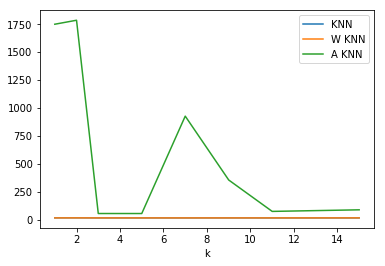

In [454]:
execTimeDf.plot.line()

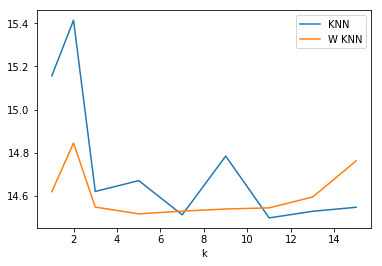

In [458]:
execTimeDf = execTimeDf.drop(['A KNN'], axis='columns')
execTimeDf.plot.line()